In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/waste'



In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2302975448275595088
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 232626178137081861
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import tensorflow as tf

# Chemin vers les images dans Google Drive
data_dir = '/content/drive/MyDrive/waste'

# Charger les images et les labels
data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   image_size=(256, 256),  # Taille des images après redimensionnement
                                                   batch_size=32,  # Taille des lots (batchs)
                                                   label_mode='int',  # Les labels sous forme d'entiers
                                                   shuffle=True)  # Mélanger les données




Found 3750 files belonging to 15 classes.


In [ ]:
print(data.class_names)


['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'clothing', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'office_paper', 'paper_cups', 'plastic_detergent_bottles', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_water_bottles']


In [ ]:
for images, labels in data:
    print(images.shape)
    break


(32, 256, 256, 3)


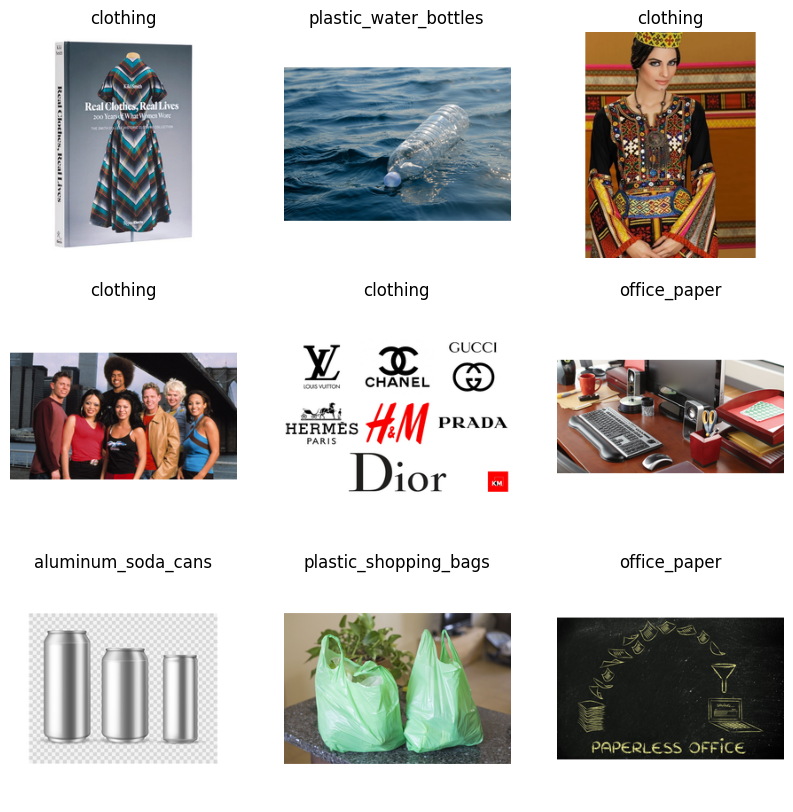

In [ ]:
import matplotlib.pyplot as plt

# Afficher quelques images et leurs labels
class_names = data.class_names  # Récupère les noms des classes
for images, labels in data.take(1):  # Prendre un batch d'images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Afficher 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.show()


**Préparation et séparation des données d'images et labels\**


Cette cellule parcourt le dataset data batch par batch (issu probablement d'un DataLoader).

Chaque image et label est sauvegardé individuellement en .npy dans des dossiers temporaires (temp_images, temp_labels).

Ensuite, les chemins sont séparés en ensembles d'entraînement et de test via train_test_split.

Enfin, les fichiers .npy sont rechargés en mémoire sous forme de tableaux NumPy complets.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Créer des dossiers temporaires pour stocker les images et labels par échantillon
os.makedirs("temp_images", exist_ok=True)
os.makedirs("temp_labels", exist_ok=True)

# Listes des chemins des fichiers
image_paths = []
label_paths = []

# Lire les données par batch et sauvegarder chaque échantillon individuellement
index = 0
for images, labels in data:
    images_np = images.numpy().astype(np.float32)
    labels_np = labels.numpy()

    for i in range(images_np.shape[0]):
        img_path = f"temp_images/image_{index}.npy"
        lbl_path = f"temp_labels/label_{index}.npy"

        np.save(img_path, images_np[i])
        np.save(lbl_path, labels_np[i])

        image_paths.append(img_path)
        label_paths.append(lbl_path)
        index += 1

print(f"Total d'échantillons sauvegardés : {index}")

# Diviser les chemins en ensembles d'entraînement et de test
train_img_paths, test_img_paths, train_lbl_paths, test_lbl_paths = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

print(f"Taille train : {len(train_img_paths)}")
print(f"Taille test : {len(test_img_paths)}")

# Charger les données réellement maintenant (dans la limite de ce que la RAM peut supporter)
train_images = np.array([np.load(p) for p in train_img_paths])
train_labels = np.array([np.load(p) for p in train_lbl_paths])
test_images = np.array([np.load(p) for p in test_img_paths])
test_labels = np.array([np.load(p) for p in test_lbl_paths])

print(f"Shape train_images : {train_images.shape}")
print(f"Shape test_images : {test_images.shape}")


Total d'échantillons sauvegardés : 3750
Taille train : 3000
Taille test : 750
Shape train_images : (3000, 256, 256, 3)
Shape test_images : (750, 256, 256, 3)


**Conversion en tf.data.Dataset et prétraitement**

Cette cellule convertit les tableaux NumPy des images et labels (train/test) en objets tf.data.Dataset.

Elle applique un redimensionnement des images à 256x256 pixels.

Elle regroupe les données en batchs de taille 32 pour l’entraînement.



In [ ]:
# Convertir les ensembles d'entraînement et de test en tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Ajouter les étapes de prétraitement comme le redimensionnement et la mise à l'échelle
train_data = train_data.map(lambda x, y: (tf.image.resize(x, (256, 256)), y)).batch(32)
test_data = test_data.map(lambda x, y: (tf.image.resize(x, (256, 256)), y)).batch(32)

print("Ensembles de données préparés pour l'entraînement.")


Ensembles de données préparés pour l'entraînement.


**Construction, compilation et entraînement du modèle CNN avec EfficientNetB1**


Data augmentation dynamique via tf.keras.Sequential pour enrichir les données d'entraînement.

Chargement d’un modèle pré-entraîné EfficientNetB1 (imagenet) sans la couche de sortie (include_top=False) avec gel des 200 premières couches.

Construction d’un modèle Sequential personnalisé avec :

GlobalAveragePooling2D, Dropout, Dense avec régularisation L2, BatchNormalization, et une sortie softmax pour 15 classes.

Compilation avec l’optimiseur Adam, une loss en SparseCategoricalCrossentropy (car labels en entier).

Ajout de callbacks :

EarlyStopping : pour éviter l’overfitting.

ReduceLROnPlateau : pour réduire le learning rate en cas de stagnation.

Entraînement du modèle sur 40 époques avec validation.

Affichage final des courbes d'accuracy et loss pour l’analyse de la performance

efficient net 1

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 351ms/step - accuracy: 0.0801 - loss: 5.2710 - val_accuracy: 0.3307 - val_loss: 3.5574 - learning_rate: 1.0000e-04
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.1660 - loss: 4.4520 - val_accuracy: 0.5267 - val_loss: 3.0390 - learning_rate: 1.0000e-04
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.2534 - loss: 3.9323 - val_accuracy: 0.6067 - val_loss: 2.6323 - learning_rate: 1.0000e-04
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 265ms/step - accuracy: 0.3316 - loss: 3.5610 - val_accuracy: 0.6640 - val_loss: 2.3526 - learning_rate: 1.0000e-04
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.3723 - loss: 3.3343 - val_accuracy: 0.7013 - val_loss: 2.2027 - learning_rate: 1.0000e-04
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.4415 - loss: 3.0413 - val_accuracy: 0.7320 - val_loss: 2.1068 - learning_rate: 1.0000e-04
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - acc

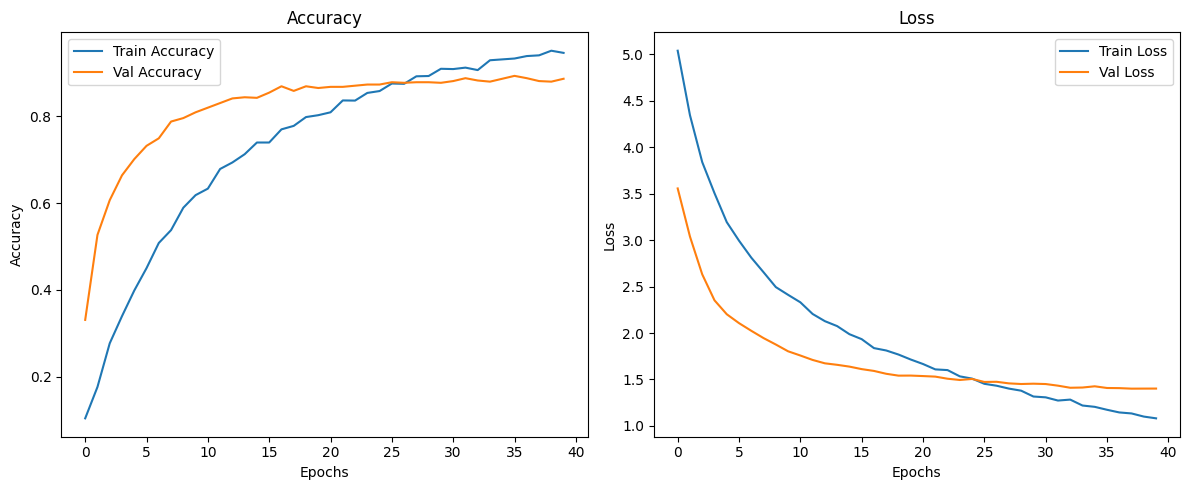

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1  # Utilisation de la version B7

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.02),
])

# Modèle de base EfficientNetB7
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True

# Gel des premières couches du modèle de base (plus de couches gelées)
for layer in base_model.layers[:200]:  # Augmenté de 150 à 200
    layer.trainable = False

# Architecture du modèle complet
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.002),
                 bias_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.Dropout(0.55),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.002),
                 bias_regularizer=regularizers.l2(0.002)),
    layers.Dropout(0.45),
    layers.Dense(15, activation='softmax')  # Sortie pour 15 classes
])

# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    weight_decay=1e-5
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks pour l'entraînement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=12,
    min_delta=0.0005,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=6,
    min_lr=1e-7,
    verbose=1
)

# Entraînement du modèle
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=40,
    callbacks=[early_stopping, reduce_lr]
)

# Affichage des courbes de performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Graphique de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Graphique de la perte (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Vérifie les noms de couches si tu veux être sûr
base_model.summary()


Model: "efficientnetb1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 5,799,924 (22.12 MB)

 Non-trainable params: 775,315 (2.96 MB)

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=19d3c141abdcfaf61ebb7216a0405ac141f83cf0dc5a646db6444c04628c1aa9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


**Interprétation des prédictions avec LIME**

Chargement dynamique d’une image utilisateur via files.upload() dans Google Colab.

Prétraitement de l’image : redimensionnement à (256, 256) et normalisation pour être compatible avec le modèle EfficientNetB1.

Prédiction de la classe la plus probable avec le modèle entraîné.

Utilisation de LIME (lime_image.LimeImageExplainer) pour interpréter localement la prédiction.

Visualisation des régions les plus importantes ayant influencé la décision du modèle avec mark_boundaries().



Saving Image_33.png to Image_33.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━

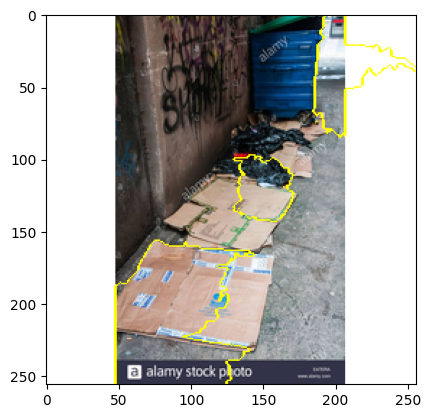

In [ ]:
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Step 1: Upload the image
uploaded = files.upload()

# Step 2: Load and preprocess the uploaded image
img_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image

# Load the image and resize to the input shape required by EfficientNetB1
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize the image to match the input scale of EfficientNetB1
img_array /= 255.0

# Step 3: Get the predicted class for the image
predicted_class = np.argmax(model.predict(img_array))

# Step 4: Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction for the selected image
explanation = explainer.explain_instance(img_array[0], model.predict)

# Step 5: Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    predicted_class,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.show()


efficientnet 3

In [ ]:
model.save("efficient1.h5")


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("efficient1.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


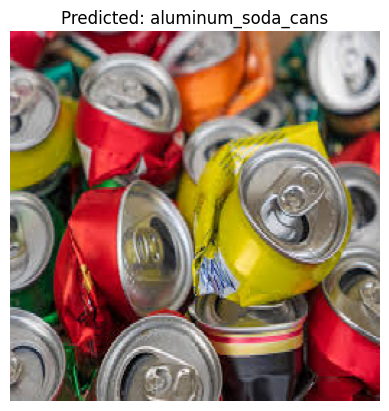

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load model (try .h5 first, fallback to SavedModel folder)
try:
    model = tf.keras.models.load_model("efficient1.h5")
except:
    model = tf.keras.models.load_model("efficient1")

# Define class names
class_names = [
    'aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'clothing',
    'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'office_paper', 'paper_cups',
    'plastic_detergent_bottles', 'plastic_shopping_bags', 'plastic_soda_bottles',
    'plastic_straws', 'plastic_water_bottles'
]

# Load and preprocess image
img_path = "can.jpg"  # make sure this image is in the same directory
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred[0])

# Show image and prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {class_names[pred_class]}")
plt.show()


**efficientnet3**

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 104s 518ms/step - accuracy: 0.0605 - loss: 5.5533 - val_accuracy: 0.2147 - val_loss: 3.7185 - learning_rate: 1.0000e-04
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 384ms/step - accuracy: 0.1027 - loss: 4.9410 - val_accuracy: 0.4280 - val_loss: 3.3077 - learning_rate: 1.0000e-04
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.1703 - loss: 4.4035 - val_accuracy: 0.5200 - val_loss: 2.8891 - learning_rate: 1.0000e-04
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.2509 - loss: 3.9698 - val_accuracy: 0.5960 - val_loss: 2.6084 - learning_rate: 1.0000e-04
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - accuracy: 0.3021 - loss: 3.5833 - val_accuracy: 0.6280 - val_loss: 2.4461 - learning_rate: 1.0000e-04
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.3724 - loss: 3.3146 - val_accuracy: 0.6827 - val_loss: 2.3152 - learning_rate: 1.0000e-04
Epoch 

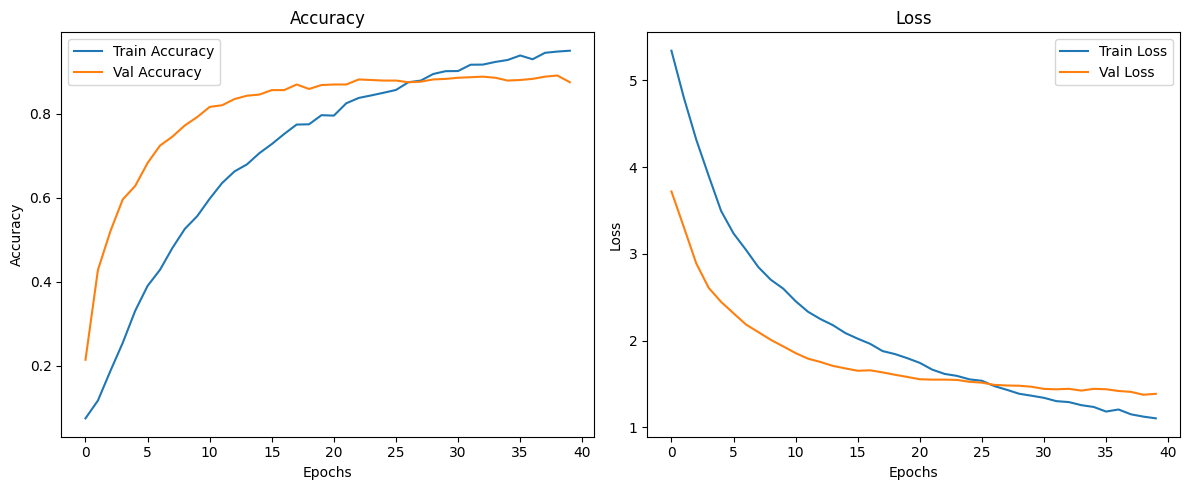

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3  # Utilisation de la version B3
import matplotlib.pyplot as plt

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),  # Augmenter la rotation
    layers.RandomZoom(0.3),  # Augmenter le zoom
    layers.RandomTranslation(0.3, 0.3),  # Augmenter la translation
    layers.RandomContrast(0.3),  # Augmenter le contraste
    layers.GaussianNoise(0.05),  # Augmenter le bruit gaussien
])

# Modèle de base EfficientNetB3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True

# Gel des premières couches du modèle de base (plus de couches gelées)
for layer in base_model.layers[:200]:  # Augmenté de 150 à 200
    layer.trainable = False

# Architecture du modèle complet
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Augmenter le dropout
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.002),
                 bias_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Augmenter le dropout
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.002),
                 bias_regularizer=regularizers.l2(0.002)),
    layers.Dropout(0.5),  # Augmenter le dropout
    layers.Dense(15, activation='softmax')  # Sortie pour 14 classes
])

# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    weight_decay=1e-5
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks pour l'entraînement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=12,
    min_delta=0.0005,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=6,
    min_lr=1e-7,
    verbose=1
)

# Entraînement du modèle
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=40,
    callbacks=[early_stopping, reduce_lr]
)

# Affichage des courbes de performance
plt.figure(figsize=(12, 5))

# Graphique de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Graphique de la perte (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


resnet50

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - accuracy: 0.1259 - loss: 2.8341 - val_accuracy: 0.3933 - val_loss: 2.1057 - learning_rate: 1.0000e-04
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 250ms/step - accuracy: 0.3510 - loss: 2.1979 - val_accuracy: 0.6333 - val_loss: 1.4625 - learning_rate: 1.0000e-04
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 268ms/step - accuracy: 0.4923 - loss: 1.8260 - val_accuracy: 0.6960 - val_loss: 1.1698 - learning_rate: 1.0000e-04
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.5834 - loss: 1.5505 - val_accuracy: 0.7853 - val_loss: 0.9921 - learning_rate: 1.0000e-04
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - accuracy: 0.6485 - loss: 1.3904 - val_accuracy: 0.7787 - val_loss: 0.9875 - learning_rate: 1.0000e-04
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - accuracy: 0.6859 - loss: 1.2446 - val_accuracy: 0.7667 - val_loss: 0.9871 - learning_rate: 1.0000e-04
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - acc

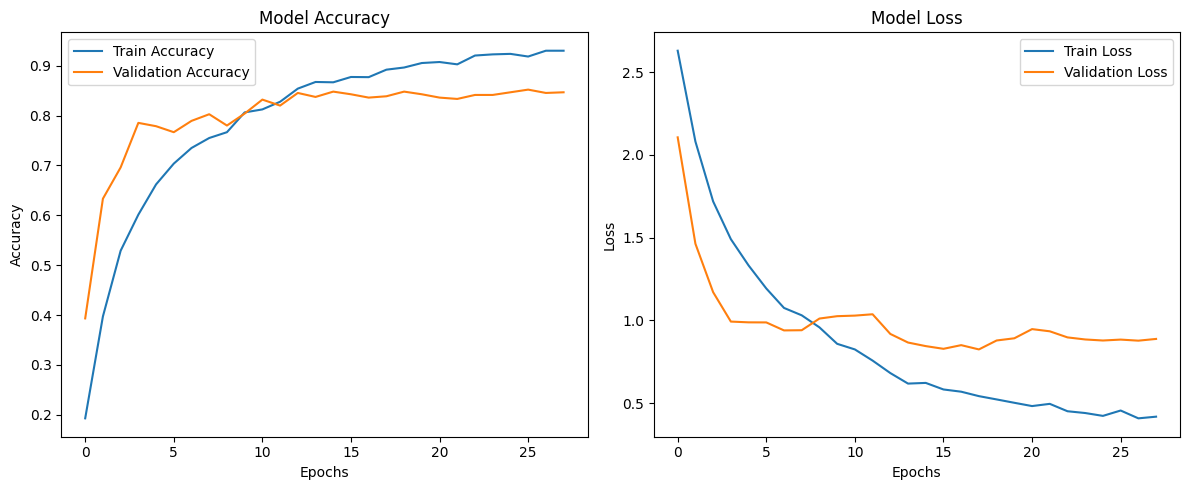

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step

Classification Report:

              precision    recall  f1-score   support

           0      0.814     0.842     0.828        57
           1      0.812     0.907     0.857        43
           2      0.925     0.875     0.899        56
           3      0.913     0.913     0.913        46
           4      0.824     0.875     0.848        48
           5      0.940     0.979     0.959        48
           6      0.735     0.800     0.766        45
           7      0.889     0.889     0.889        45
           8      0.787     0.787     0.787        61
           9      0.780     0.939     0.852        49
          10      0.872     0.872     0.872        47
          11      0.957     0.898     0.926        49
          12      0.780     0.627     0.696        51
          13      0.808     0.824     0.816        51
          14      0.767     0.611     0.680        54

    accuracy                          0.839       750
   macro avg  

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.3),
    layers.RandomTranslation(0.3, 0.3),
    layers.RandomContrast(0.3),
    layers.GaussianNoise(0.05),
], name="data_augmentation")

# --- 2. Chargement du modèle ResNet50 pré-entraîné ---
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model.trainable = True

# On gèle les premières couches pour garder les bonnes features
for layer in base_model.layers[:150]:
    layer.trainable = False

# --- 3. Construction du modèle complet ---
model = models.Sequential([
    data_augmentation,  # Augmentation des images
    base_model,  # Modèle ResNet50 pré-entrainé
    layers.BatchNormalization(),  # Normalisation des activations
    layers.GlobalAveragePooling2D(),  # Réduit les dimensions des caractéristiques
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),  # Couche dense avec régularisation
    layers.Dropout(0.5),  # Dropout pour éviter l'overfitting
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),  # Autre couche dense
    layers.Dropout(0.3),  # Dropout
    layers.Dense(15, activation='softmax')  # 15 classes
])

# --- 4. Compilation ---
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# --- 5. Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# --- 6. Entraînement ---
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=40,
    callbacks=[early_stopping, reduce_lr]
)

# --- 7. Visualisation des courbes d'apprentissage ---
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# --- 8. Évaluation détaillée ---
y_true = np.concatenate([y for _, y in test_data], axis=0)
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=3))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Charger une nouvelle image
img_path = 'belar.jfif'  # Remplace par le chemin de ton image
img = image.load_img(img_path, target_size=(256, 256))  # Redimensionner à la taille d'entrée du modèle
img_array = image.img_to_array(img)  # Convertir l'image en un tableau numpy
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour correspondre à l'entrée du modèle

# Faire une prédiction
predictions = model.predict(img_array)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Désactiver les axes pour un affichage plus propre
plt.show()

# Afficher les prédictions avec le nom de la classe
predicted_class = np.argmax(predictions, axis=1)  # Trouver la classe prédite avec la plus haute probabilité
print(f"Classe prédite : {class_names[predicted_class[0]]}")
print(f"Probabilité de la classe : {predictions[0][predicted_class[0]] * 100:.2f}%")


In [ ]:
model.save("efficient3waste15.keras")
